# References

Custom image labeling will be done using this tool https://tzutalin.github.io/labelImg/. A tutorial for this software can be found here https://www.youtube.com/watch?v=_FNfRtXEbr4&ab_channel=Pysource.

to work with the coco dataset we will be using pycocotools to filter the dataset and gluoncv for some of the additional features it contains (gluoncv uses pycocotools for working with the coco dataset). a tutorial can be found here https://github.com/ivangrov/Datasets-ASAP/blob/master/%5BPart%203%5D%20COCO%20Dataset/COCO_Dataset.ipynb/ and official documentation can be found here https://cv.gluon.ai/build/examples_datasets/mscoco_tracking.html.

pycocotools is a parser built by the coco team to make filtering of the dataset easier. For a better understanding of how the dataset itself is formatted this is a great resource https://www.youtube.com/watch?v=h6s61a_pqfM&ab_channel=ImmersiveLimit (most important info starts at about 4:27).

### Note:

Windows has caused issues with numpy making an installation of gluoncv with windows to be impossible or at least very difficult. gluoncv will not be used as of the last run of this data processing

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random 
import os
import pandas as pd
from PIL import Image

the next 4 cells are just following the pycocotools tutorial to make sure that everything is set up and running correctly. here we are setting our filepaths, loading our data and showing images with annotations.

for this excercies we are just using the validation set because it is relatively quick to download but the same process will work on the full dataset. when exploring the dataset through the coco website there are approximately 66k total images with people in them.

In [2]:
dataDir='COCODataset2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco=COCO(annFile)

filters = ['person']

catIds = coco.getCatIds(catNms=filters);
imgIds = coco.getImgIds(catIds=catIds);
print("total number of images with people: {}".format(len(imgIds)))
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
total number of images with people: 2693


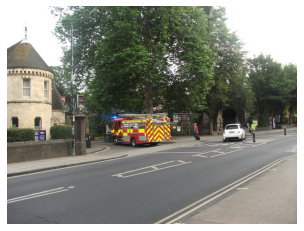

In [3]:
fn = os.getcwd() + "\COCODataset2017\images\\val\\"
I = io.imread(fn + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

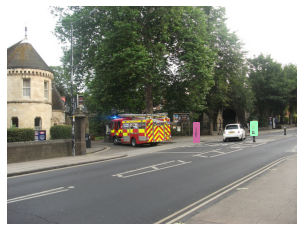

In [4]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=[1], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [5]:
img

{'license': 2,
 'file_name': '000000350003.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000350003.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-17 19:51:18',
 'flickr_url': 'http://farm9.staticflickr.com/8445/7858130416_bf868d66a5_z.jpg',
 'id': 350003}

In [6]:
def count_instances(imgIds):
    instances = []
    for img in imgIds:
        annIds = coco.getAnnIds(imgIds=img, catIds=[1], iscrowd=None)
        anns = coco.loadAnns(annIds)
        instances.append(len(anns))
    return pd.DataFrame({"Instances": instances})

In [7]:
instances = count_instances(imgIds)
instances.describe()

Instances
count  2693.000000
mean      4.086149
std       4.149420
min       1.000000
25%       1.000000
50%       2.000000
75%       6.000000
max      14.000000

the coco dataset saves bounding boxes as (x_topleft, y_topleft, width, height) wheras yolo takes bounding box as (class_label, x_center, y_center, width, height) all normalized to image size in a .txt file with the same name as the image file.

The first thing that we want to do is look at all of the images with a high annotation area and filter these out.

In [8]:
def image_data(imgIds):
    avg_height = []
    avg_width = []
    avg_percent_class = []
    high_percent_area = []
    imgIds_returned = []
    for Id in imgIds:
        img = coco.loadImgs(Id)
        avg_height.append(img[0]['height'])
        avg_width.append(img[0]['width'])
        
        annIds = coco.getAnnIds(imgIds=Id, catIds=[1], iscrowd=None)
        anns = coco.loadAnns(annIds)
        percent_class_area = 0
        for ann in anns:
            percent_class_area += ann['area']
            
        percent_class_area = percent_class_area/(img[0]['height']*img[0]['width'])
        if percent_class_area > 0.65:
            high_percent_area.append([Id, percent_class_area])
        else:
            imgIds_returned.append(Id)
        avg_percent_class.append(percent_class_area)
        
    return pd.DataFrame({"avg_height": avg_height, "avg_width": avg_width, "avg_percent_area":avg_percent_class}), high_percent_area, imgIds_returned

In [9]:
data, high_percent_area, imgIds = image_data(imgIds)
data.describe()

avg_height    avg_width  avg_percent_area
count  2693.000000  2693.000000       2693.000000
mean    484.554029   571.584850          0.168901
std      99.013487    95.862798          0.180794
min     145.000000   200.000000          0.000073
25%     426.000000   500.000000          0.028691
50%     480.000000   640.000000          0.104307
75%     555.000000   640.000000          0.251141
max     640.000000   640.000000          1.014031

This function takes all of the images Ids that we have kept to this point and saves them th the target folder.

In [10]:
import shutil
target_folder = 'yolo_images'
def move_img(imgIds):
    for Id in imgIds:
        img = coco.loadImgs(Id)
        oldFp = os.getcwd() + "\COCODataset2017\images\\val\\" + img[0]['file_name']
        newFp = os.getcwd() + "\yolo_images\\" + img[0]['file_name']
        shutil.copy2(oldFp, newFp)

This function converts all of the COCO annotations into yolo annotations.

In [11]:
def yolo_ann(imgIds):
    folder_path = os.getcwd() + "\yolo_images\\"
#     Load each image sequentially bu ID and store annotation information
    for Id in imgIds:
        img = coco.loadImgs(Id)
        img_name = img[0]['file_name'].split('.')[0]
        img_height = img[0]['height']
        img_width = img[0]['width']
        annIds = coco.getAnnIds(imgIds=Id, catIds=[1], iscrowd=None)
        anns = coco.loadAnns(annIds)
        
#         Create a new text file and recreate the bounding boxes in a text file in yolo format
        with open(os.path.join(folder_path, img_name) +  '.txt', 'w') as text:
            
            for ann in anns:
                box = ann['bbox']
                x_center = (box[0] + box[2]/2.0)/(img_width)
                y_center = (box[1] + box[3]/2.0)/(img_height)
                width = box[2]/img_width
                height = box[3]/img_height
                
                line = str(0) + ' ' + str(x_center) + ' ' + str(y_center) + ' ' + str(width) + ' ' + str(height)
                text.write(line + "\n")
            
            
        

0.6662917192382812


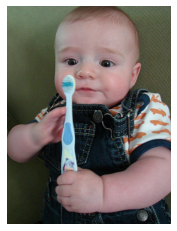

0.6872830920040246


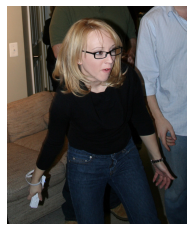

0.6650981405333335


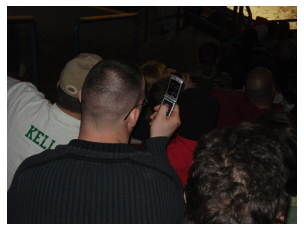

0.698284036885246


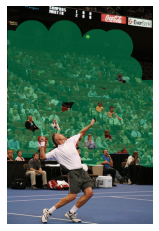

0.8482815458083833


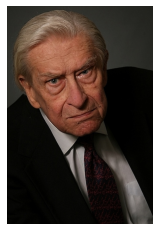

0.9586676317138669


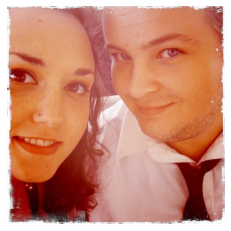

0.6969505405042921


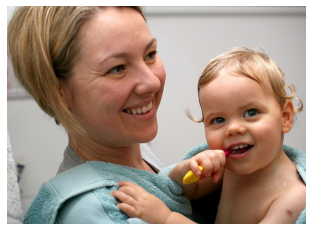

0.9281202579775281


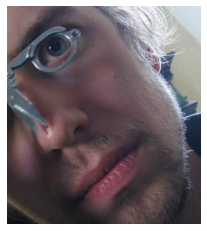

0.759330971842448


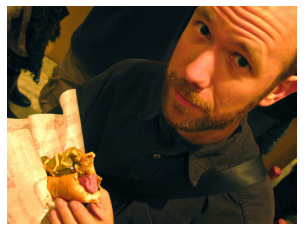

0.7293160469850355


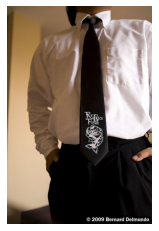

0.7599685187353632


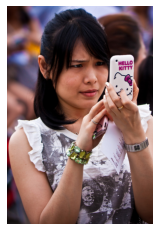

0.7136931674473068


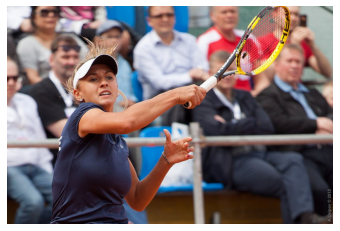

0.8171701562666667


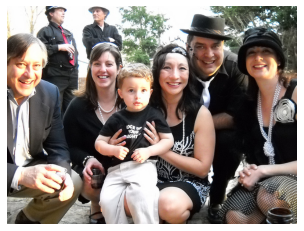

0.6681835475352113


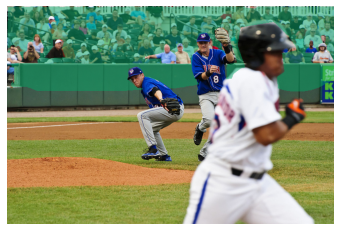

0.7152428226102941


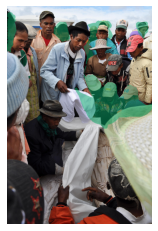

0.7323550217725407


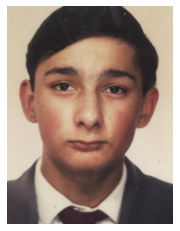

0.8542124796911592


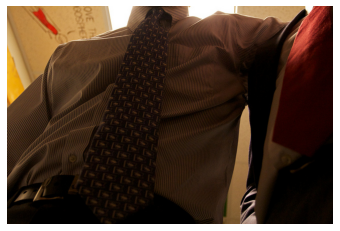

0.7678589770507812


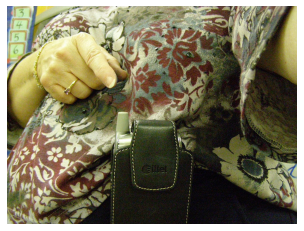

0.6986454515886507


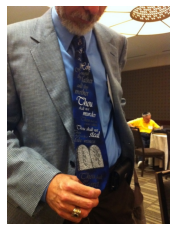

0.8094059152879903


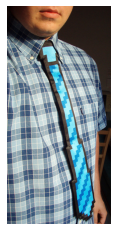

0.8004806472000001


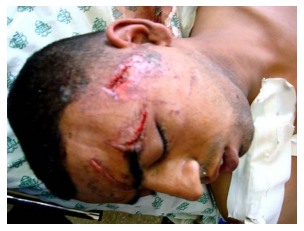

0.6583673400187964


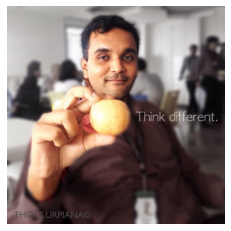

0.7954454367937853


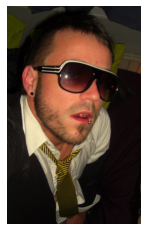

0.8616891996688741


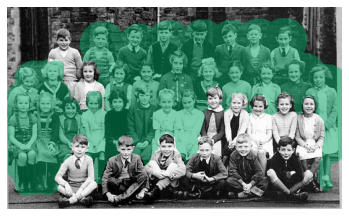

0.7268281884765626


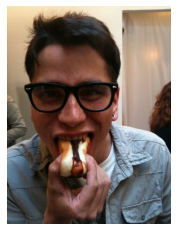

0.8060723909814639


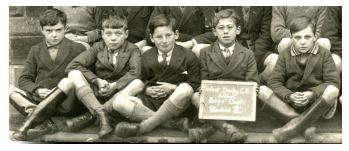

0.743322665236209


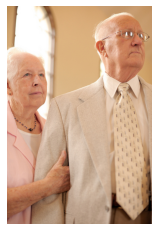

0.8401164541015625


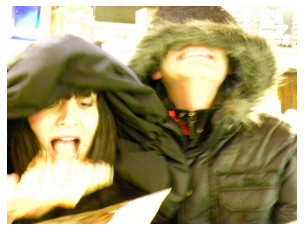

0.6732328522135417


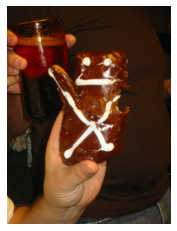

0.6757689098666666


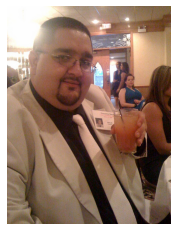

0.7960917181303114


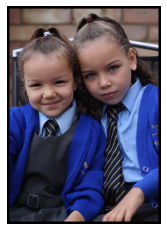

0.6541673220524017


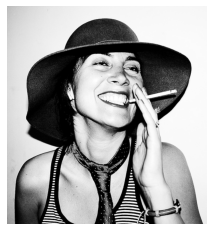

0.6946646952618454


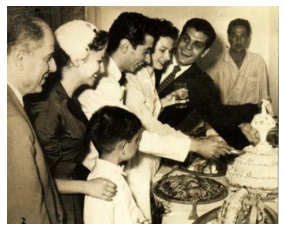

0.8280986285355838


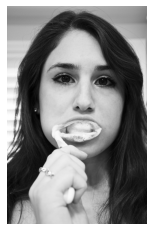

0.6969315614022243


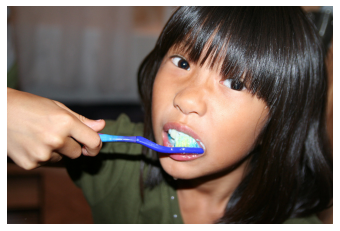

0.6815026904296874


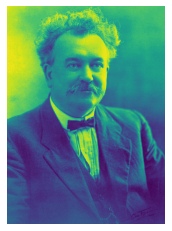

0.7918574966989435


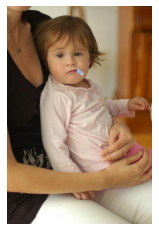

0.7238193020220589


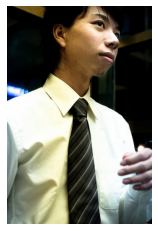

0.938756226270444


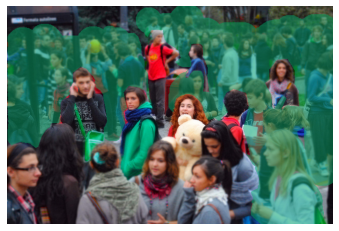

1.0140308270980045


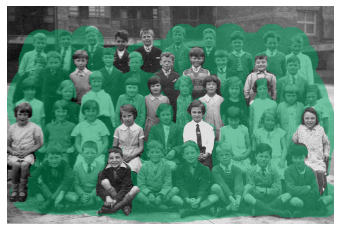

0.978170553897472


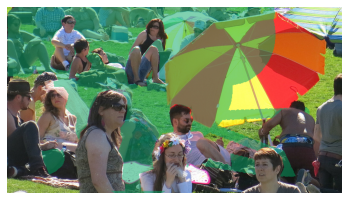

0.6565001109521713


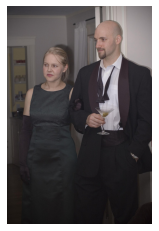

0.6750838068033854


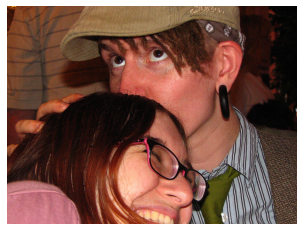

0.6997977821333332


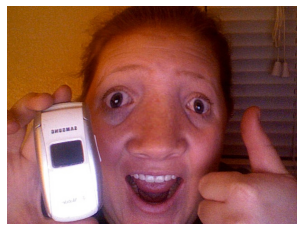

0.8914259755747126


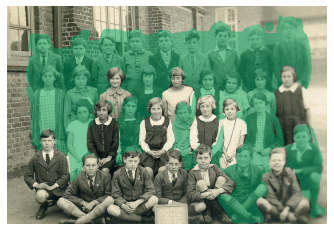

0.678436304274339


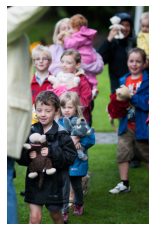

0.7129392301333334


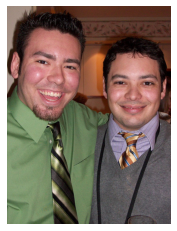

0.6698087486979166


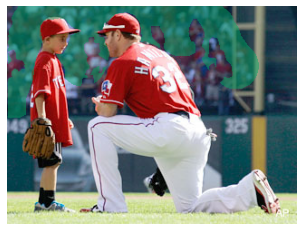

0.6628215219039686


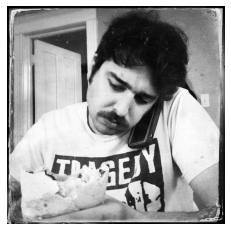

0.783787203097394


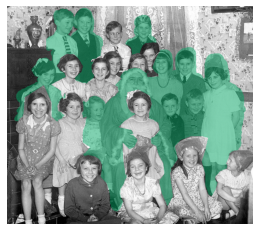

0.9212286590676227


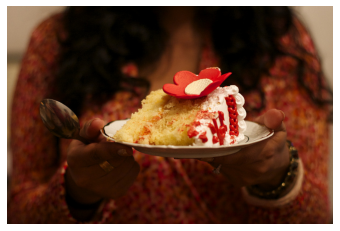

0.7325684529622397


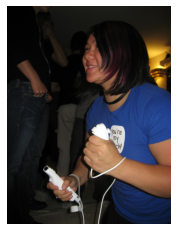

0.6684803833406178


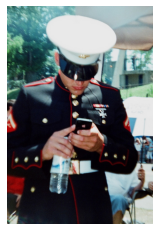

0.7066815348588108


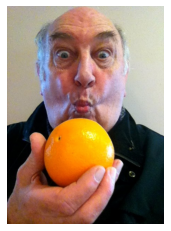

0.686167548828125


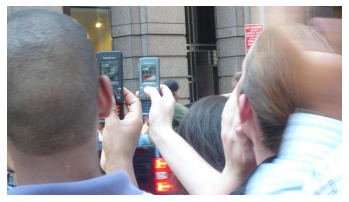

0.6516495253999999


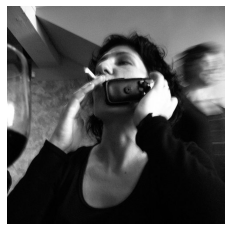

0.7095749663085936


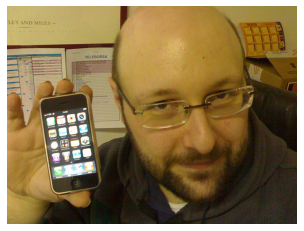

0.881327639485677


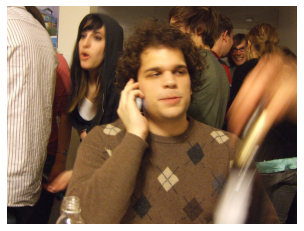

0.7437926282552083


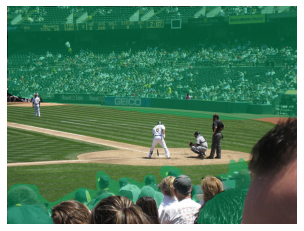

0.8682548668619791


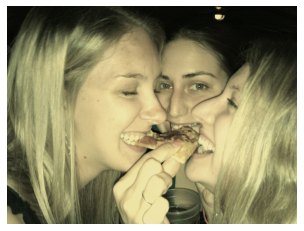

0.6982499741210938


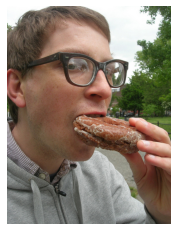

0.7306906776932084


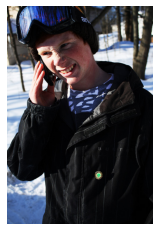

0.8632907251602564


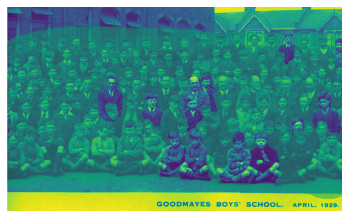

0.8406152071257559


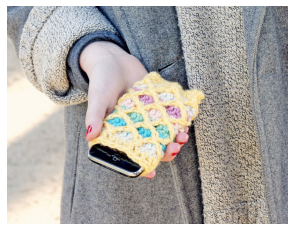

0.6976652557333334


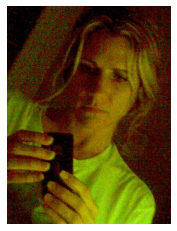

In [12]:
def show_high_area_images(imgIds_area):
    for item in imgIds_area:
        img = coco.loadImgs(item[0])[0]
        fn = os.getcwd() + "\COCODataset2017\images\\val\\"
        print(item[1])
        I = io.imread(fn + img['file_name'])
        plt.imshow(I); plt.axis('off')
        
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=[1], iscrowd=True)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)
        plt.show()
show_high_area_images(high_percent_area)

As expected a decent amount of the high area images were not relevant to training our model so we will disregard them and filter them out of our training set. This accounted for about 2.5% of our total data. many of these images also had crowd labeling which is not useful for our training.

In [28]:
move_img(imgIds)

In [29]:
yolo_ann(imgIds)

This function will create the required text files for darknet.

- target: the directory that the images will be placed in. 
- folders: the folders that this finction will take images from. (list) 
- train_percent: percentage to use for training

In [54]:
def clean_data(folder):
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            with open(folder + '\\' + file, 'r') as text:
                lines = text.readlines()
                newlines=[]
                for line in lines:
                    newline = '0'+line[1:]
                    newlines.append(newline)
                print(file, newlines)
                text.close()
            with open(folder + '\\' + file, 'w+') as text:
                text.writelines(newlines)
                text.close()

In [55]:
clean_data('images')

csgo000001.test.txt ['0 0.5 0.5 0.371875 0.928125']
csgo000001.txt ['0 0.5 0.5 0.371875 0.928125']
csgo000002.txt ['0 0.5 0.5 0.034375 0.071875']
csgo000003.txt []
csgo000004.txt ['0 0.5 0.5 0.73125 0.990625']
csgo000005.txt []
csgo000006.txt ['0 0.5 0.5 0.046875 0.1125']
csgo000007.txt []
csgo000008.txt []
csgo000009.txt []
csgo000010.txt []
csgo000011.txt ['0 0.5 0.5 0.415625 0.784375']
csgo000012.txt []
csgo000013.txt []
csgo000014.txt ['0 0.5 0.5 0.36875 0.7']
csgo000015.txt ['0 0.5 0.5 0.115625 0.253125']
csgo000016.txt ['0 0.5 0.5 0.084375 0.18125']
csgo000017.txt ['0 0.5 0.5 0.571875 0.840625']
csgo000018.txt []
csgo000019.txt []
csgo000020.txt ['0 0.5 0.5 0.2375 0.70625']
csgo000021.txt []
csgo000022.txt ['0 0.5 0.5 0.25625 0.446875']
csgo000023.txt ['0 0.5 0.5 0.253125 0.69375']
csgo000024.txt []
csgo000025.txt ['0 0.5 0.5 0.078125 0.20625']
csgo000026.txt []
csgo000027.txt []
csgo000028.txt ['0 0.5 0.5 0.065625 0.134375']
csgo000029.txt []
csgo000030.txt ['0 0.5 0.5 0.0625 0.

csgo000296.txt ['0 0.628 0.456 0.091 0.338\n']
csgo000297.txt ['0 0.321 0.631 0.092 0.456\n', '0 0.432 0.489 0.015 0.081\n', '0 0.552 0.481 0.013 0.061\n']
csgo000298.txt ['0 0.412 0.557 0.022 0.119\n', '0 0.577 0.525 0.015 0.08\n']
csgo000299.txt ['0 0.221 0.507 0.031 0.101\n', '0 0.258 0.493 0.018 0.065\n', '0 0.621 0.514 0.038 0.129\n']
csgo000300.txt ['0 0.772 0.472 0.058 0.25\n', '0 0.535 0.493 0.065 0.322\n']
csgo000301.txt ['0 0.399 0.593 0.083 0.404\n']
csgo000302.txt ['0 0.256 0.531 0.019 0.043\n', '0 0.509 0.531 0.017 0.061\n', '0 0.647 0.571 0.024 0.081\n']
csgo000303.txt ['0 0.275 0.362 0.034 0.142\n', '0 0.587 0.451 0.087 0.401\n']
csgo000304.txt ['0 0.543 0.437 0.054 0.257\n']
csgo000305.txt ['0 0.521 0.574 0.08 0.442\n']
csgo000306.txt ['0 0.309 0.472 0.06 0.274\n', '0 0.698 0.409 0.024 0.154\n', '0 0.759 0.452 0.071 0.251\n']
csgo000307.txt ['0 0.177 0.335 0.042 0.12\n', '0 0.469 0.456 0.039 0.159\n', '0 0.789 0.454 0.047 0.156\n']
csgo000308.txt ['0 0.511 0.439 0.029 0

csgo000562.txt ['0 0.344 0.598 0.036 0.138\n']
csgo000563.txt ['0 0.215 0.613 0.067 0.198\n', '0 0.513 0.507 0.018 0.074\n']
csgo000564.txt ['0 0.372 0.473 0.025 0.129\n']
csgo000565.txt ['0 0.372 0.474 0.025 0.13\n']
csgo000566.txt ['0 0.194 0.656 0.084 0.252\n', '0 0.535 0.596 0.028 0.168\n']
csgo000567.txt ['0 0.248 0.306 0.009 0.05\n', '0 0.267 0.308 0.011 0.046\n']
csgo000568.txt ['0 0.198 0.44 0.029 0.042\n', '0 0.608 0.496 0.009 0.031\n']
csgo000569.txt ['0 0.414 0.421 0.036 0.112\n', '0 0.675 0.429 0.021 0.07\n']
csgo000570.txt ['0 0.477 0.479 0.024 0.091\n', '0 0.561 0.467 0.015 0.071\n']
csgo000571.txt ['0 0.479 0.462 0.026 0.133\n']
csgo000572.txt ['0 0.527 0.517 0.009 0.041\n']
csgo000573.txt ['0 0.489 0.494 0.037 0.09\n']
csgo000574.txt ['0 0.515 0.506 0.009 0.029\n', '0 0.54 0.507 0.011 0.03\n']
csgo000575.txt ['0 0.389 0.524 0.026 0.099\n']
csgo000576.txt ['0 0.55 0.442 0.009 0.032\n', '0 0.545 0.482 0.012 0.049\n']
csgo000577.txt ['0 0.524 0.499 0.021 0.043\n', '0 0.647

csgo000860.txt ['0 0.546 0.511 0.029 0.072\n']
csgo000861.txt ['0 0.422 0.563 0.041 0.174\n']
csgo000862.txt ['0 0.438 0.474 0.015 0.066\n', '0 0.464 0.519 0.03 0.118\n']
csgo000863.txt ['0 0.373 0.539 0.037 0.144\n', '0 0.548 0.549 0.044 0.166\n', '0 0.603 0.531 0.031 0.131\n']
csgo000864.txt ['0 0.65 0.541 0.047 0.193\n', '0 0.302 0.564 0.071 0.232\n', '0 0.381 0.56 0.06 0.232\n', '0 0.436 0.465 0.011 0.051\n']
csgo000865.txt ['0 0.474 0.462 0.011 0.039\n', '0 0.488 0.468 0.014 0.053\n']
csgo000866.txt ['0 0.337 0.537 0.065 0.356\n', '0 0.458 0.402 0.015 0.056\n', '0 0.474 0.402 0.014 0.055\n']
csgo000867.txt ['0 0.309 0.242 0.095 0.322\n']
csgo000868.txt ['0 0.254 0.352 0.086 0.354\n', '0 0.665 0.355 0.093 0.363\n', '0 0.801 0.368 0.13 0.377\n']
csgo000869.txt ['0 0.155 0.435 0.021 0.07\n', '0 0.254 0.568 0.08 0.312\n', '0 0.352 0.54 0.057 0.265\n', '0 0.538 0.483 0.032 0.156\n']
csgo000870.txt ['0 0.703 0.458 0.02 0.064\n']
csgo000871.txt ['0 0.412 0.5 0.015 0.038\n']
csgo000872.tx

csgo001143.txt ['0 0.427 0.337 0.02 0.084\n']
csgo001144.txt ['0 0.457 0.435 0.061 0.186\n']
csgo001145.txt ['0 0.112 0.449 0.047 0.059\n', '0 0.196 0.449 0.015 0.041\n', '0 0.623 0.449 0.013 0.041\n', '0 0.637 0.449 0.015 0.046\n']
csgo001146.txt ['0 0.789 0.423 0.018 0.047\n', '0 0.04 0.426 0.022 0.056\n', '0 0.062 0.426 0.024 0.057\n']
csgo001147.txt ['0 0.07 0.445 0.014 0.045\n', '0 0.377 0.438 0.015 0.031\n', '0 0.656 0.44 0.032 0.047\n', '0 0.572 0.442 0.012 0.034\n', '0 0.792 0.447 0.02 0.044\n']
csgo001148.txt ['0 0.143 0.45 0.017 0.051\n', '0 0.333 0.444 0.009 0.035\n', '0 0.293 0.441 0.031 0.056\n', '0 0.402 0.441 0.008 0.032\n', '0 0.511 0.442 0.008 0.031\n', '0 0.594 0.443 0.011 0.036\n']
csgo001149.txt ['0 0.117 0.445 0.019 0.053\n', '0 0.255 0.444 0.014 0.051\n', '0 0.579 0.439 0.011 0.041\n', '0 0.751 0.443 0.05 0.065\n']
csgo001150.txt ['0 0.177 0.449 0.015 0.045\n', '0 0.219 0.448 0.042 0.065\n', '0 0.593 0.442 0.009 0.031\n', '0 0.618 0.442 0.017 0.036\n']
csgo001151.

In [12]:
from random import shuffle
def train_test_darknet(target, folders, train_percent):
    img_list =[]
    for folder in folders:
        for file in os.listdir(folder):
            if file.endswith(".jpg"):
                filename = target + file
                img_list.append(filename)
    shuffle(img_list)
    train_count = int(len(img_list)*train_percent)
    print(train_count)
    train = img_list[:train_count]
    test = img_list[train_count:]
    
    with open('train.txt', 'w+') as train_file:
        for img in train:
            train_file.write(img + "\n")
        train_file.close()
        
    with open('test.txt', 'w+') as test_file:
        for img in test:
            test_file.write(img + "\n")
        test_file.close()
        

In [13]:
train_test_darknet('data/obj/', ['images', 'yolo_images'], 0.8)

3156
